# 설비 예측 보전을 위한 딥러닝 기법
이 노트북은 [Deep Learning Basics for Predictive Maintenance](https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb)
를 한글로 번역한 노트북입니다.


딥러닝은 사물 인식과 이미지 분류와 같은 일부 도메인에서 탁월한 성능을 보여준다는 것을 입증했습니다. 또한 시계열 데이터가 중요한 역할을 하는 금융 등 도메인에서도 인기를 받았습니다. 설비 예측 보전(Predictive Maintenance) 역시 특정 딥러닝 알고리즘으로 부터 이익을을 얻기 위해 고장을 예측할 수 있는 패턴을 찾는 것을 목표로 하기 때문에 데이터를 수집하고 상태를 모니터링하는 도메인입니다. 딥러닝 기법 중, Long Short Term Memory([LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)) 모형은 시퀀스 학습에 매우 유용하다는 점 때문에 설비 예측 보전 도메인에 특히 도움이 될 수 있습니다. LSTM은 고장 패턴을 탐지하기 위해 더 긴 시점을 돌아볼 수 있는(과거의 시점에 대한 정보를 가중치를 주어 잘 잊지않는) 알고리즘이기 때문입니다. 이 노트북에서 우리는 <b>항공기 엔진의 남은 사용 수명을 예측</b>하기 위해 [Predictive Maintenance Template](https://gallery.cortanaintelligence.com/Collection/Predictive-Maintenance-Template-3)에 설명된 데이터 셋 및 기본적인 LSTM 모델링을 수행할 것입니다. 요약하자면, <b>시뮬레이션된 항공기 센서 값을 사용하여 향후 항공기 엔진이 언제 고장날지 예측하여 유지보수를 미리 계획하는 것</b>이 목표입니다.  

이 노트북은 <b>설비 예측 보전 영역에 딥러닝을 적용하고자 하는 초보자를 위한 튜토리얼 역할</b>을 하며, 예측을 위해 하나의 데이터(센서 변수)만 이용하는 간단한 시나리오를 사용합니다.이보다 더 발전된 설비 예측 보전 시나리오에서는 딥러닝 모델링에서 다른 유형의 처리 방법이 필요한 데이터(과거 유지관리 기록, 오류 로그, 기계 및 운영자 특성 등)가 존재합니다. 설비 예측 보전은 딥러닝이 상용화된 영역이 아니기 때문에, 이를 적용하는 것은 연구적인 영역일 것입니다.  

이 노트북은 Microsoft Cognitive Toolkit [CNTK](https://docs.microsoft.com/en-us/cognitive-toolkit/Using-CNTK-with-Keras)를 백-엔드로 사용한 [keras](https://keras.io/) 딥러닝 라이브러리를 사용합니다.

Github Source: [@Azure](https://github.com/Azure/lstms_for_predictive_maintenance)

Github Korean Translator: [@SSANGMAN](https://github.com/SSANGMAN)

In [1]:
#!pip install wget
import wget # 템플릿에서 데이터를 불러오려면 반드시 설치 필요함

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Setting seed for reproducability
np.random.seed(1234)  


from sklearn.metrics import confusion_matrix, recall_score, precision_score

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, SimpleRNN, Flatten
%matplotlib inline

Using TensorFlow backend.


## 데이터 수집
분석을 시작하기에 앞서, Azure 저장소에서 훈련, 테스트 및 실제값 데이터를 받아오겠습니다. <b>훈련 데이터는 "cycle"을 시간 단위로 하는 여러 개의 다변량 시계열과 그에 대한 센서 변수 21개로 구성</b>됩니다. 각 시계열은 동일한 모델의 다른 엔진에서 생성되는 것으로 가정할 수 있을 것입니다. 테스트 데이터는 훈련 데이터와 동일한 데이터 스키마를 가지고 있습니다. 다만, 엔진 고장이 언제 발생하는지 테스트 데이터에는 존재하지 않습니다. 마지막으로, 실제값 데이터는 테스트 데이터에서 엔진의 나머지 작동 횟수를 제공합니다. 이 노트북에서 사용되는 데이터 유형에 대한 자세한 내용은 [Predictive Maintenance Template](https://gallery.cortanaintelligence.com/Collection/Predictive-Maintenance-Template-3)에서 확인할 수 있습니다.

In [2]:
# 데이터 수집 - Azure blog로부터 데이터를 불러옴
train_url = 'http://azuremlsamples.azureml.net/templatedata/PM_train.txt'
test_url = 'http://azuremlsamples.azureml.net/templatedata/PM_test.txt'
truth_url = 'http://azuremlsamples.azureml.net/templatedata/PM_truth.txt'

wget.download(train_url, './dataset/PM_train.txt')
wget.download(test_url, './dataset/PM_test.txt')
wget.download(truth_url, './dataset/PM_truth.txt')

100% [..................................................................................] 429 / 429

'./dataset/PM_truth (1).txt'

## 데이터 불러오기

### Train Datset
항공기 엔진 고장 데이터
- 마지막 Cycle은 고장난 시점입니다.

In [3]:
# 훈련용 데이터 불러오기
train_df = pd.read_csv('./dataset/PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)  # NaN값으로 저장된 불필요한 컬럼 제거
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']  # header = None으로 설정했기 때문에 변수명을 다시 설정

### Test Dataset
항공기 엔진 작동 데이터
- 데이터가 고장 발생 시점을 나타내지 않습니다. 
- 즉, 마지막 Cycle이 고장난 시점을 나타내지 않습니다.

In [4]:
# 테스트 데이터 불러오기
test_df = pd.read_csv('./dataset/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

### Truth Dataset
Test Dataset의 각 엔진에 대한 잔여 Cycle 정보
- Test Dataset에서 엔진 고장까지 남은 Cycle 제공합니다.

In [5]:
# 실제값 데이터 불러오기
truth_df = pd.read_csv('./dataset/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

## 데이터 확인

In [6]:
train_df = train_df.sort_values(['id','cycle'])  # 데이터프레임을 id와 cycle을 기준으로 오름차순 정렬
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [7]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [8]:
truth_df.head()

,0
0,112
1,98
2,69
3,82
4,91


## 데이터 전처리
첫 번째 단계는 [Predictive Maintenance Template](https://gallery.cortanaintelligence.com/Collection/Predictive-Maintenance-Template-3)에서 수행한 것처럼 엔진의 남은 내용연수(RUL), label1과 label2에 대한 훈련 데이터 라벨을 생성하는 것입니다. 여기서는 "label1"에 대한 이진 분류 문제로, <b>"w1(30) 사이클 내에 엔진이 고장나는가?"</b>에 대한 질문에 답하고자 합니다.

In [9]:
# 데이터 라벨링 - RUL 컬럼 생성
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
# id별로 cycle의 최대값에 대한 데이터를 생성
rul.columns = ['id', 'max'] 
train_df = train_df.merge(rul, on=['id'], how='left') # 훈련 데이터와 병합
train_df['RUL'] = train_df['max'] - train_df['cycle'] # 훈련 데이터에 id별 최대 cycle에서 cycle을 뺀 RUL 컬럼을 생성
train_df.drop('max', axis=1, inplace=True) # id별 최대 cycle 컬럼 제거
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [10]:
# 훈련 데이터에 라벨 컬럼 생성
w1 = 30
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 ) # RUL이 w1보다 작거나 같으면 1, 아니면 0의 label1 컬럼 생성 

[Predictive Maintenance Template](https://gallery.cortanaintelligence.com/Collection/Predictive-Maintenance-Template-3)에서, cycle 컬럼은 훈련에 사용되므로 포함시킬 것입니다. 이제, 훈련 데이터를 MinMaxScaler를 이용해 최대-최소 정규화하겠습니다.

In [11]:
# 최대최소 정규화
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2']) # 정규화시킬 컬럼 선택
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), # 정규화 수행
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0.01108


이제, 테스트 데이터를 준비합니다. 먼저 훈련 데이터에 적용된 MinMax 정규화 파라미터를 사용하여 테스트 데이터를 정규화시킵니다.

In [12]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), # 정규화 수행
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


다음으로, 실제 라벨 데이터를 사용하여 테스트 데이터에 대한 라벨을 생성합니다.

In [13]:
# 테스트 데이터 max 컬럼 생성
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index() # 테스트 데이터 id별 cycle 최대값 데이터 생성
rul.columns = ['id', 'max'] # 컬럼명 변경 max값은 엔진별 사용 횟수
truth_df.columns = ['more'] # 잔존 cycle 컬럼명을 more로 변경
truth_df['id'] = truth_df.index + 1 # truth_df에 id 컬럼 생성
truth_df['max'] = rul['max'] + truth_df['more'] 
# 테스트 데이터의 작동 횟수와 고장까지 남은 잔여 작동 횟수를 더함
## 사용 횟수 + 잔여 작동 횟수 = 총 작동 횟수 = 고장 지점
truth_df.drop('more', axis=1, inplace=True)

In [14]:
# 테스트 데이터 RUL 컬럼 생성
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle'] # 총 작동 횟수 - 사용 횟수 = 남은 유효 수명
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [15]:
# 테스트 데이터 라벨 컬럼 생성. (w1)
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0


이제부터, 우리는 label1에 대한 이진 분류 모델을 훈련하고 평가하기 위해 일련의 기계 학습 모델을 사용하는 템플릿 [Predictive Maintenance Template Step 2B of 3](https://gallery.cortanaintelligence.com/Experiment/Predictive-Maintenance-Step-2B-of-3-train-and-evaluate-binary-classification-models-2)의 결과와 비교할 RNN, LSTM 모델을 훈련시킬 것입니다. 

## Modeling
기존의 설비 예측 보전 기계 학습 모델은 도메인 전문지식과 유사한 방법을 사용하여 유의미한 특성을 구성하는 피쳐 엔지니어링(Feature Engineering) 기반이었습니다. <b>피쳐 엔지니어링을 통한 기계학습 모델링은 문제 시나리오와 기업마다 가용 데이터가 다르기 때문에 모델을 재사용하기 어렵다는 단점이 존재합니다.</b> 설비 예측 보전 영역에서 딥러닝을 적용하는 데 있어서 가장 매력적인 부분은 모델이 데이터에서 자동으로(알아서) 좋은 특성을 추출하여 일련의 피쳐 엔지니어링 과정을 생략할 수 있다는 사실입니다. (역자:좋은 특성을 추출하기 위해서는 Layer 구성과 파라미터 조정을 잘 해야 함.)  

시계열 도메인에서 LSTM을 사용할 때, 한 가지 중요한 파라미터는 모델이 이전 시점을 돌아볼 수 있는 시퀀스의 길이입니다. [Predictive Maintenance Template](https://gallery.cortanaintelligence.com/Collection/Predictive-Maintenance-Template-3)에서 확인해보면, 21개 센서 변수에 대한 이동 평균 및 이동 표준 편차 이동 특성을 계산하기 위한 window_size = 5 사이클 선택과 유사하다고 볼 수 있습니다. LSTM을 사용하는 아이디어는 모델을 <b>수동으로 엔지니어링하는 것보다, 센서 변수의 Window 시퀀스에서 다소 추상적인 특성을 추출할 수 있도록 하는 것</b>입니다. 예측은 고장이 발생하기 전에, Window 내에 이러한 센서 변수의 패턴이 발견될 경우 입니다. 따라서 LSTM에 의해 그러한 패턴이 인코딩 되어야합니다.  

LSTM의 매우 중요한 장점은 기존의 RNN(Recurrent Neural Network)에 비해 전통적인 피쳐 엔지니어링으로는 달성하기 어려운 <b>긴 시점(Window Size)를 기억할 수 있다</b>는 점입니다. 예를 들어, 50 사이클의 긴 시점에 걸친 이동 평균을 계산하면, 장기간에 걸친 값의 평활화 및 추상화로 인한 정보 손실이 발생할 것입니다. 하지만 모든 값을 사용하면 더 나은 결과를 얻을 수 있을 것입니다. 매우 긴 시점에 대한 피쳐 엔지니어링은 좋은 방법이 아닐 수 있지만, <b>LSTM은 더 긴 시점에 사용할 수 있고 매시점(모든 cycle)의 모든 정보를 입력으로 사용할 수 있습니다.</b> RNN및 LSTM에 익숙하지 않다면, 이해하기 쉽지 않을 수 있습니다.아래에서는 어떻게 접근하는지 설명하겠습니다.

### RNN
LSTM을 이해하기 위해선 먼저 <b>RNN(Recurrent Neural Network)</b>을 이해해야 합니다. RNN은 은닉층에서 활성화 함수를 통해 나온 결과값을 출력층 방향으로도 보내면서, 다시 은닉층의 다음 계산의 입력으로 보내는 특징을 가지고 있습니다. RNN에서는 은닉층에서 활성화 함수를 통해 결과를 내보내는 역할을 하는 노드(node)를 셀(cell)이라고 합니다. cell은 <b>이전의 값을 기억하려고 하는 일종의 메모리 역할을 수행</b>할 수 있으므로 메모리 셀 또는 RNN 셀이라고도 부릅니다.

은닉층의 메모리  셀은 각각의 시점(time-step)에서 바로 이전 시점에서의 은닉층의 메모리 셀에서 나온 값들을 계속해서 자신의 입력으로 보내는 재귀적 활동을 하고 있습니다. 이는 <b>현재 시점 t에서 메모리 셀이 갖고있는 값은 과거의 메모리 셀들의 값에 영향을 받은 것</b>임을 의미합니다.

메모리 셀이 다음 시점 t+1에 다시 자신에게 보내는 이 값을 은닉 상태(hidden state)라고 합니다. 즉, 현재 시점 t의 메모리 셀은 이전 시점 t-1에서의 메모리 셀이 보낸 은닉 상태값을 다시 계산을 위한 입력값으로 사용합니다. 아래의 그림에서 입력층의 x_t는 현재 시점 t에서의 입력값, 출력층의 h_t는 현재 시점 t에서의 출력층의 출력값을 의미합니다.

![](https://camo.githubusercontent.com/973c3ae224a52ff2b86b799cfcb0069f60395e36/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f313630302f312a4e4b6877734f594e555435785537507966365a6e68672e706e67)

In [16]:
# 긴 시점을 정의. cycle sqeunce를 50으로 설정.
sequence_length = 50

먼저 엔진 id 3의 고장 전 50 cycle 센서 변수를 예를 들어 확인해보겠습니다. 엔진 id별 각 시점에 대한 정보를 LSTM에 제공할 것입니다.

In [17]:
# 데이터 시각화 준비
engine_id3 = train_df[train_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + sequence_length]
print(engine_id3_50cycleWindow.shape)
# RUL 최소값: 엔진 고장까지 남은 수명 
## RUL 최소값 + 50: 엔진 고장 전까지 엔진이 작동할 때마다 측정된 50개의 센서값

cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

(51, 29)


In [18]:
test_df.loc[test_df['id'] == 3].head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1
80,3,1,0.494253,0.583333,0.0,0.0,0.246988,0.411598,0.441256,0.0,...,0.415929,0.0,0.333333,0.0,0.0,0.658915,0.554819,0.00000,194,0
81,3,2,0.724138,0.250000,0.0,0.0,0.307229,0.572705,0.432984,0.0,...,0.359369,0.0,0.416667,0.0,0.0,0.542636,0.586716,0.00277,193,0
82,3,3,0.534483,0.750000,0.0,0.0,0.533133,0.342926,0.427583,0.0,...,0.295498,0.0,0.250000,0.0,0.0,0.426357,0.667219,0.00554,192,0
83,3,4,0.436782,0.416667,0.0,0.0,0.364458,0.424678,0.323599,0.0,...,0.442093,0.0,0.583333,0.0,0.0,0.449612,0.653687,0.00831,191,0
84,3,5,0.477011,0.250000,0.0,0.0,0.382530,0.262699,0.398717,0.0,...,0.496730,0.0,0.333333,0.0,0.0,0.519380,0.540044,0.01108,190,0


In [19]:
train_df.loc[train_df['id'] == 3].head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,cycle_norm
479,3,1,0.545977,0.916667,0.0,0.0,0.250000,0.286898,0.268062,0.0,...,0.368603,0.0,0.250000,0.0,0.0,0.635659,0.588650,178,0,0.00000
480,3,2,0.442529,0.500000,0.0,0.0,0.436747,0.348812,0.276334,0.0,...,0.269334,0.0,0.166667,0.0,0.0,0.720930,0.749379,177,0,0.00277
481,3,3,0.574713,0.333333,0.0,0.0,0.259036,0.211685,0.318197,0.0,...,0.219700,0.0,0.416667,0.0,0.0,0.689922,0.582712,176,0,0.00554
482,3,4,0.545977,0.333333,0.0,0.0,0.388554,0.197951,0.228055,0.0,...,0.265871,0.0,0.250000,0.0,0.0,0.620155,0.822839,175,0,0.00831
483,3,5,0.614943,0.833333,0.0,0.0,0.228916,0.227600,0.199190,0.0,...,0.378607,0.0,0.250000,0.0,0.0,0.589147,0.724662,174,0,0.01108


In [20]:
truth_df.head()

,id,max
0,1,143
1,2,147
2,3,195
3,4,188
4,5,189


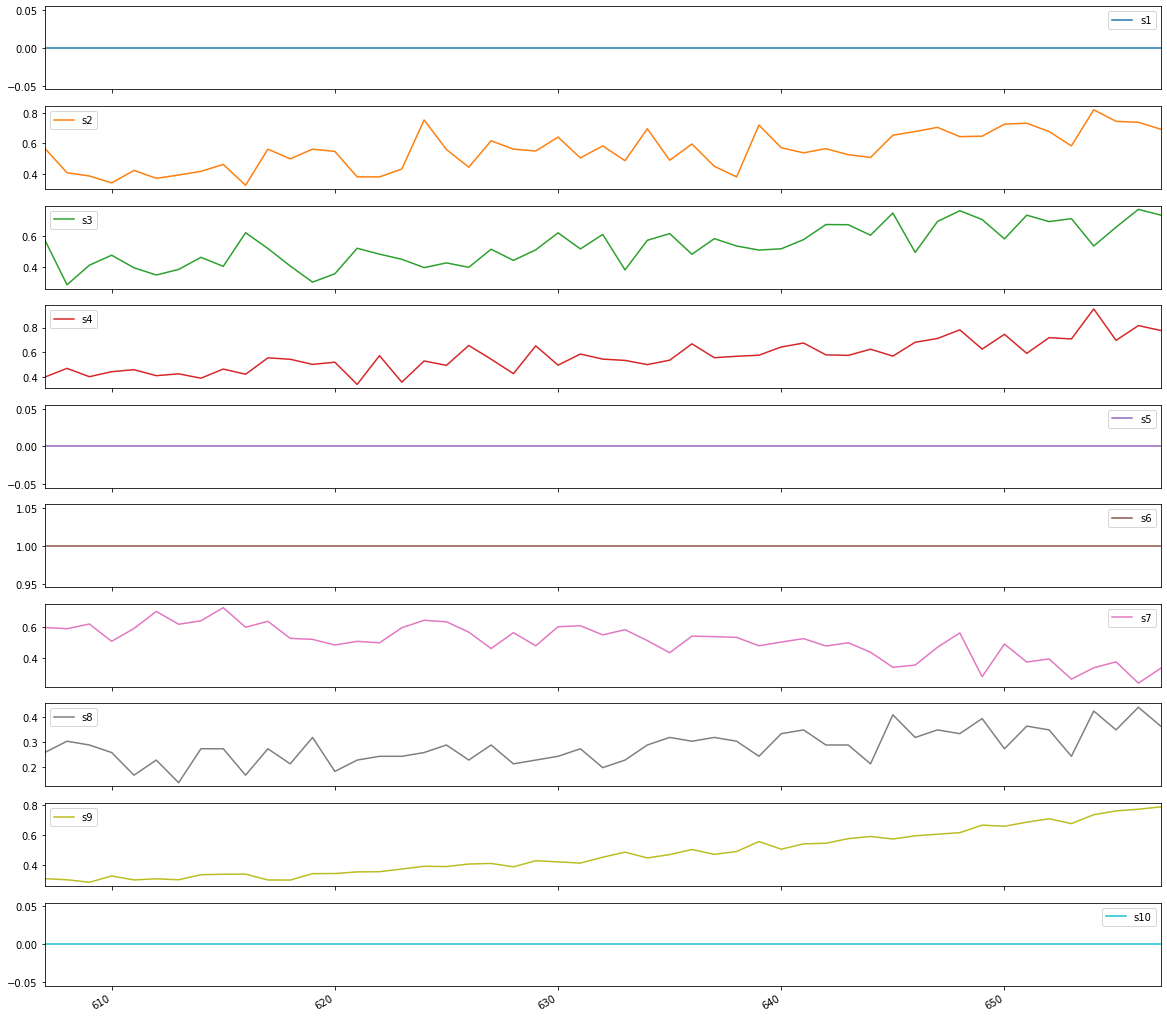

In [21]:
# 고장 시점 이전 센서 1-10까지 그래프 생성
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

In [22]:
engine_id3_50cycleWindow.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,cycle_norm
607,3,129,0.517241,0.916667,0.0,0.0,0.569277,0.576848,0.399392,0.0,...,0.404386,0.0,0.416667,0.0,0.0,0.565891,0.484949,50,0,0.354571
608,3,130,0.465517,0.500000,0.0,0.0,0.409639,0.284282,0.470290,0.0,...,0.541362,0.0,0.333333,0.0,0.0,0.550388,0.590721,49,0,0.357341
609,3,131,0.258621,0.666667,0.0,0.0,0.388554,0.411380,0.403106,0.0,...,0.408619,0.0,0.500000,0.0,0.0,0.488372,0.490058,48,0,0.360111
610,3,132,0.425287,0.416667,0.0,0.0,0.343373,0.476128,0.443282,0.0,...,0.531743,0.0,0.500000,0.0,0.0,0.527132,0.682270,47,0,0.362881
611,3,133,0.442529,0.250000,0.0,0.0,0.424699,0.394593,0.459656,0.0,...,0.460947,0.0,0.500000,0.0,0.0,0.472868,0.580088,46,0,0.365651


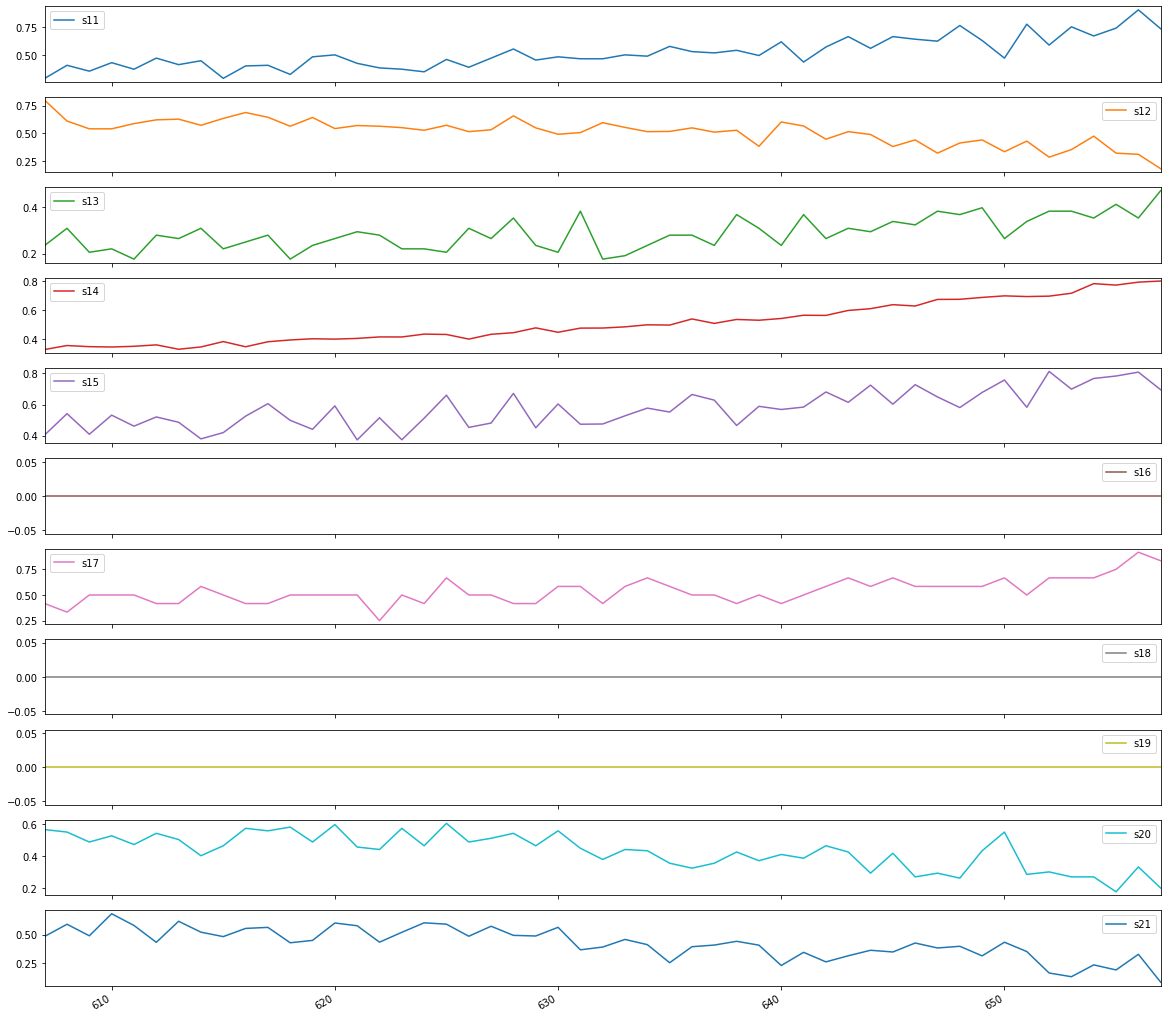

In [23]:
# 고장 시점 이전 센서 11-21까지 그래프 생성
ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

RNN과 [Keras LSTM](https://keras.io/layers/recurrent/) 레이어는 3차원(sample, time steps, feature)의 숫자 배열 형태의 입력을 필요로 합니다. 여기서 sample은 훈련 시퀀스의 수, time steps는 윈도우 또는 시퀀스 길이, 특성은 time step별 시퀀스의 특성 수입니다.

![](https://miro.medium.com/max/532/1*AQKRJsRdWx2HZ85H1yWoKw.png)

In [24]:
# (samples, time steps, features) = (Batch_size, Time_steps, Input_dim) 형태로 데이터를 변경
def gen_sequence(id_df, seq_length, seq_cols):
    """ Window 길이가 일치하는 시퀀스만 고려하겠습니다. 
    즉, RUL이 50 이상인 id만 사용합니다. 
    사용하지 못한 데이터를 사용하려면 padding 이라는 기법을 사용합니다."""
    data_array = id_df[seq_cols].values # 모델링에 사용할 변수들의 값들을 array 형식으로 생성
    num_elements = data_array.shape[0] # array의 모든 원수 개수
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)): #zip(range(0,20581), range(50, 20630))
        yield data_array[start:stop, :] 
        
    # index 0 부터 50까지 
    # index 1 부터 51까지
    # index 2 부터 52까지.....
#                .
#                .
#                .
    # index 20581 부터 20630까지
    ## 50개씩 분할하여 저장

In [61]:
train_df[['id','cycle']].values.shape[0]

20631

In [25]:
train_df.shape

(20631, 29)

In [26]:
# feature 추출 (input dimension: s1~s21, setting1~setting3, cycle_norm => 총 25개)
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [27]:
# 시퀀스 생성
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique()) # id별 window size = 50에 대한 array를  시퀀스로 생성

In [28]:
train_df['id'].nunique()

100

In [29]:
test_df['id'].nunique()

100

In [30]:
# 생성된 시퀀스를 numpy array 형태로 변경
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

In [31]:
#  라벨을 생성하는 함수 정의
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [32]:
# 라벨 생성
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32) # np.concatenate: 배열 결합
label_array.shape

(15631, 1)

#### 모델 구축

RNN의 입력차원은 다음과 같습니다.
- Input_dim: 피쳐의 개수
- Time_steps: window_size(50)
- Batch_size

Batch_size는 모델을 적합시킬 때 명시해줄 것입니다.

In [33]:
nb_features = seq_array.shape[2] # Input_dim
nb_out = label_array.shape[1] # Output_dim

model = Sequential() #모델 선언

model.add(SimpleRNN(input_shape = (sequence_length, nb_features), 
                   units = 100,
                   return_sequences = True))
model.add(Dropout(0.2))

model.add(SimpleRNN(units = 50,
                   return_sequences = True))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(units = nb_out, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

W1122 12:38:01.108721  2716 deprecation_wrapper.py:119] From C:\Users\Frank\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1122 12:38:01.110724  2716 deprecation_wrapper.py:119] From C:\Users\Frank\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1122 12:38:01.114723  2716 deprecation_wrapper.py:119] From C:\Users\Frank\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1122 12:38:01.311902  2716 deprecation_wrapper.py:119] From C:\Users\Frank\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1122 12:38:01.322796  2716 deprecation.py:506

In [34]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 50, 100)           12600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 50, 50)            7550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2501      
Total params: 22,651
Trainable params: 22,651
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
%%time
# 모델 적합
model.fit(seq_array, label_array, epochs=10, batch_size=50, validation_split=0.25, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Train on 11723 samples, validate on 3908 samples
Epoch 1/10
11723/11723 [==============================] - 17s 1ms/step - loss: 0.1791 - acc: 0.9270 - val_loss: 0.0576 - val_acc: 0.9775
Epoch 2/10
11723/11723 [==============================] - 18s 2ms/step - loss: 0.0803 - acc: 0.9655 - val_loss: 0.0707 - val_acc: 0.9703
Wall time: 35.6 s


In [36]:
# 훈련 데이터 성능결과
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size = 50)
print('Accurracy: {}'.format(scores[1]))

15631/15631 [==============================] - 6s 411us/step
Accurracy: 0.9728104402187514


In [37]:
# 예측값에 대한 Confusion Matrix 생성
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=100)
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

15631/15631 [==============================] - 4s 242us/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12312,   219],
       [  206,  2894]], dtype=int64)

In [38]:
# 정밀도(precision), 재현율(recall)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.9296498554449084 
 recall =  0.9335483870967742


이제, 테스트 데이터의 성능을 확인해 볼 차례입니다. [Predictive Maintenance Template Step 1 of 3](https://gallery.cortanaintelligence.com/Experiment/Predictive-Maintenance-Step-1-of-3-data-preparation-and-feature-engineering-2)에서, 각 엔진 id에 대한 마지막 사이클 데이터만 테스트를 목적으로 보관합니다. 결과를 템플릿과 비교하기 위해 테스트 데이터의 각 id에 대한 마지막 시퀀스를 선택하겠습니다.

In [39]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 25)

In [40]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
# time_step을 50으로 잡았기 때문에 시퀀스가 50 이상인 id는 True, 50 미만은 False로 반환

In [41]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
# test_df.groupby('id')['label1'].nth(-1): id별 label1에 대한 값을 반환
# [y_mask].values: 시퀀스가 50 미만인 id는 제외
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
## 라벨 데이터를 1차원 배열로 변환
label_array_test_last.shape

(93, 1)

In [42]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 25)
(93, 1)


In [43]:
# 테스트 데이터 성능평가
scores_test_rnn = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test_rnn[1]))

Accurracy: 0.989247311827957


In [44]:
# 예측값에 대한 confusion matrix 계산 및 생성
y_pred_test = model.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[68,  0],
       [ 1, 24]], dtype=int64)

In [45]:
# 정밀도(precision), 재현율(recall) 계산
precision_test_rnn = precision_score(y_true_test, y_pred_test)
recall_test_rnn = recall_score(y_true_test, y_pred_test)
f1_test_rnn = 2 * (precision_test_rnn * recall_test_rnn) / (precision_test_rnn + recall_test_rnn)
print( 'Precision: ', precision_test_rnn, '\n', 'Recall: ', recall_test_rnn,'\n', 'F1-score:', f1_test_rnn )

Precision:  1.0 
 Recall:  0.96 
 F1-score: 0.9795918367346939


####  RNN의 한계
바닐라 RNN은 출력 결과가 이전의 계산 결과에 의존한다는 것에 주목해야합니다. 하지만, RNN은 비교적 짧은 시퀀스에 대해서만 효과를 보이는 단점이 존재합니다. 즉<b> RNN의 시점(time-step)이 길어질 수록 이전 시점의 정보가 뒤로 충분히 전달되지 못하는 현상이 발생합니다.</b> 아래의 그림은 첫번째 입력값인 x_1의 정보량을 짙은 남색으로 표현했을 때, 색이 점차 얕아지는 것으로 시점이 지날수록 x1의 정보량이 손실되어가는 과정을 표현하였습니다. 뒤로 갈수록 x_1의 정보량은 손실되고, 시점이 충빈히 긴 상황에서는 x_1의 전체 정보에 대한 영향력은 거의 의미가 없을 수 있습니다.

![](https://mblogthumb-phinf.pstatic.net/MjAxODA3MDJfMTA3/MDAxNTMwNTM3NDA5MzA4.XVdGLg1QMZm-7GbqMi-qzp1kJ3HTL0xQIJYFkGuGDY8g.AEf4MVfIILOCyFG9mdSisodq6NkltDIxG3moV34azRsg.PNG.magnking/image.png?type=w800)

### LSTM

전통적인 RNN의 이러한 단점을 보완한 RNN의 일종을 장단기 메모리(Long Short Term Memory)라고 하며, LSTM이라고 합니다. LSTM은 은닉층의 메모리 셀에 입력 게이트, 망각 게이트, 출력 게이트를 추가하여 불필요한 기억을 지우고, 기억해야할 것들을 정합니다.

요약하면 LSTM은 은닉 상태(hidden state)를 계산하는 식이 전통적인 RNN보다 조금 더 복잡해졌으며 셀 상태(cell state)라는 값을 추가하였습니다. 아래의 그림에서는 t시점의 셀 상태를 C_t로 표현하고 있습니다. LSTM은 RNN과 비교하여 긴 시퀀스의 입력을 처리하는데 탁월한 성능을 보입니다.

셀 상태는 위의 그림에서 왼쪽에서 오른쪽으로 가는 굵은 선입니다. 셀 상태 또한 이전에 배운 은닉 상태처럼 이전 시점의 셀 상태가 다음 시점의 셀 상태를 구하기 위한 입력으로서 사용됩니다.

은닉 상태값과 셀 상태값을 구하기 위해서 새로 추가 된 3개의 게이트를 사용합니다. 각 게이트는 삭제 게이트, 입력 게이트, 출력 게이트라고 부르고 이 3개의 게이트에는 공통적으로 시그모이드 함수가 존재합니다. 시그모이드 함수를 지나면 0과 1사이의 값이 나오게 되는데 이 값들을 가지고 게이트를 조절합니다.

![](https://camo.githubusercontent.com/ec728ab585b370e1576a25e8148fe4333640f58a/68747470733a2f2f63646e2d696d616765732d312e6d656469756d2e636f6d2f6d61782f313630302f302a4c796659334d6f77396543596c6a376f2e)

#### 모델 구축

첫 번째 레이어는 LSTM 레이어로, 100개의 셀을 가진 다음 50개의 셀을 가진 또다른 LSTM 레이어로 구성되어 있습니다. 또한 각 LSTM 레이어 뒤에 Dropout을 적용하여 과대적합을 제어합니다. 최종 레이어는 이진 분류 문제이기 때문에, 시그모이드 활성화 함수를 적용한 Dense 레이어입니다.

In [46]:
# 모델 구축
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
%%time
# 모델 적합
model.fit(seq_array, label_array, epochs=10, batch_size=50, validation_split=0.25, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Train on 11723 samples, validate on 3908 samples
Epoch 1/10
11723/11723 [==============================] - 55s 5ms/step - loss: 0.1826 - acc: 0.9243 - val_loss: 0.0924 - val_acc: 0.9573
Epoch 2/10
11723/11723 [==============================] - 40s 3ms/step - loss: 0.1286 - acc: 0.9479 - val_loss: 0.1023 - val_acc: 0.9550
Wall time: 1min 36s


In [51]:
# 훈련 데이터 성능결과
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=50)
print('Accurracy: {}'.format(scores[1]))

15631/15631 [==============================] - 21s 1ms/step
Accurracy: 0.9618066662477902


In [52]:
# 예측값에 대한 Confusion Matrix 생성
y_pred = model.predict_classes(seq_array,verbose=1, batch_size=50)
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

15631/15631 [==============================] - 17s 1ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[12016,   515],
       [   82,  3018]], dtype=int64)

In [53]:
# 정밀도(precision), 재현율(recall)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.8542315312765355 
 recall =  0.9735483870967742


In [54]:
# 테스트 데이터 성능평가
scores_test_lstm = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test_lstm[1]))

Accurracy: 0.9784946307059257


In [55]:
# 예측값에 대한 confusion matrix 계산 및 생성
y_pred_test = model.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[66,  2],
       [ 0, 25]], dtype=int64)

In [56]:
# 정밀도(precision), 재현율(recall) 계산
precision_test_lstm = precision_score(y_true_test, y_pred_test)
recall_test_lstm = recall_score(y_true_test, y_pred_test)
f1_test_lstm= 2 * (precision_test_lstm * recall_test_lstm) / (precision_test_lstm + recall_test_lstm)
print( 'Precision: ', precision_test_lstm, '\n', 'Recall: ', recall_test_lstm,'\n', 'F1-score:', f1_test_lstm )

Precision:  0.9259259259259259 
 Recall:  1.0 
 F1-score: 0.9615384615384615


In [57]:
result_df = pd.DataFrame([[scores_test_rnn[1],precision_test_rnn,recall_test_rnn,f1_test_rnn],
                         [scores_test_lstm[1],precision_test_lstm, recall_test_lstm, f1_test_lstm],
                         [0.94, 0.952381, 0.8, 0.869565]],
                        columns = ['Accuracy','Precision','Recall', 'F1-score'],
                        index = ['RNN','LSTM','Template Best Model'])

result_df

,Accuracy,Precision,Recall,F1-score
RNN,0.989247,1.000000,0.96,0.979592
LSTM,0.978495,0.925926,1.00,0.961538
Template Best Model,0.940000,0.952381,0.80,0.869565


Comparing the above test results to the predictive maintenance template, we see that the LSTM results are better than the template. It should be noted that the  data set used here is very small and deep learning models are known to perform superior with large datasets so for a more fair comparison larger datasets should be used.

위의 테스트 결과를 설비 예측 보전 템플릿과 비교해보면 LSTM의 결과가 템플릿보다 우수하는 것을 알 수 있습니다.

## Future Directions and Improvements
This tutorial covers the basics of using deep learning in predictive maintenance and many predictive maintenance problems usually involve a variety of data sources that needs to be taken into account when applying deep learning in this domain. Additionally, it is important to tune the models for the right parameters such as window size. Here are some suggestions on future directions on improvements:
- Try different window sizes.
- Try different architectures with different number of layers and nodes.
- Try tuning hyperparmeters of the network.
- Try predicting RUL (regression) such as in  [Predictive Maintenance Template Step 2A of 3](https://gallery.cortanaintelligence.com/Experiment/Predictive-Maintenance-Step-2A-of-3-train-and-evaluate-regression-models-2) and label2 (multi-class classification) such as in [Predictive Maintenance Template Step 2C of 3](https://gallery.cortanaintelligence.com/Experiment/Predictive-Maintenance-Step-2C-of-3-train-and-evaluation-multi-class-classification-models-2).
- Try on larger data sets with more records.
- Try a different problem scenario such as in [Predictive Maintenance Modelling Guide](https://gallery.cortanaintelligence.com/Notebook/Predictive-Maintenance-Modelling-Guide-R-Notebook-1) where multiple other data sources are involved such as maintenance records.

